----------
# Introduction
----------

This notebook provides code template and quetions as listed under the Problem Formulation in the intruction PDF. 

**Please Implement the TODOs and write your answer under the following
question prompt**

After you finish, go to File -> Download -> Download '.ipynb', save the notebook and submit to GradeScope. 

*   Gradescope: https://www.gradescope.com/courses/351582
*   Course entry code: 5V3YRX




Do not close the cell outputs after running the code cells, so that all logging and plots will be saved in the notebook for grading.

---
# Preparation
---

## Enable GPU settings
Go to Edit -> Notebook Settings -> Select "GPU" under Hardware Accelerator

In [ ]:
!nvidia-smi

Tue Jan 18 08:59:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    30W /  70W |   1172MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import libraries

In [ ]:
import os
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import typing
from typing import Tuple

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Activation, RandomFlip, RandomRotation
from tensorflow.keras.callbacks import EarlyStopping

# TF setting:
tf.config.experimental_run_functions_eagerly(True)

# We still need some useful helper functions from sklearn
from sklearn.model_selection import train_test_split
from skimage.transform import resize

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
# Config logger
import logging
logging.basicConfig()
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG) # Can switch to INFO

## Helper Functions Shared by Both Parts

In [ ]:
# Download wafer data set from the shared url
def download(save_path, url):
	#Parse save_path and create directory if not present
    save_dir = os.path.dirname(save_path)
	
    try:
        os.mkdir(save_dir)
        logger.info(f'Created new folder {save_dir}')
    except FileExistsError:
        pass

    # Retrieve pickle file from the given url and save to the path 
    downloaded = urllib.request.urlretrieve(url, save_path)
    logger.info(f'File saved to {downloaded[0]}')

# TODO: Implement a function that shows one wafer map example from each of failure categories
def visualize_data_categories(df):
    # This function should generate a single plot showing one wafer map image for each failure type.
    categories = pd.unique(df['failureType'])
    for category in categories:
        if category != 'unknown':
            temp = df.loc[df['failureType'] == category]
            plt.imshow(temp['waferMap'].sample().iloc[0])
            plt.title(category)
            plt.show()

-----------
# Part 1: Wafer Map Failure Classification on the Simple Data Set Generated By TA
-----------

We start with a simple data set generated by TAs. The data is stored as a Pandas DataFrame (atable). TAs provided the code for downloading the data set from a shared URLs to your GoogleColab file system.

### Data Downloading


In [ ]:
data_url_1 = 'https://ucsb.box.com/shared/static/1f5mvjhxsydp94e70b2hgdmivev54mej.pkl' # url for the 1st data set

save_path_1 = './hw1/dataset_one.pkl' # you can change this to any path string

# Let's call the download function to get our 2 data sets
dataset_1 = download(save_path_1, data_url_1)

# Read the data frame from downloaded pickle files
df1 = pd.read_pickle(save_path_1)
# Let's see what's in the data frame 
logger.debug(df1.info())

INFO:__main__:File saved to ./hw1/dataset_one.pkl
DEBUG:__main__:None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3300 entries, 0 to 3299
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   waferMap     3300 non-null   object
 1   failureType  3300 non-null   object
dtypes: object(2)
memory usage: 51.7+ KB


Q.1 (2 pts): Download the first data set and visualize the failure types by randomly selecting onewafer map from each failure type. Generate a single plot showing one wafer map image foreach of the six failure types.

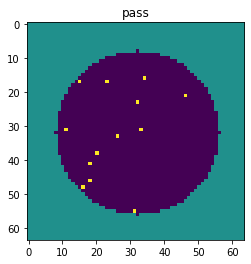

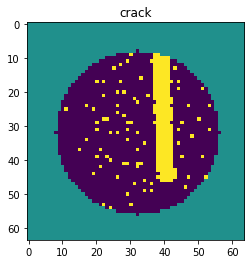

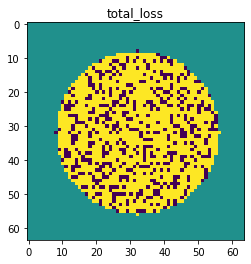

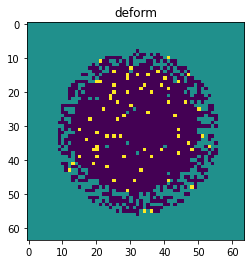

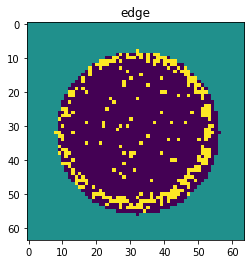

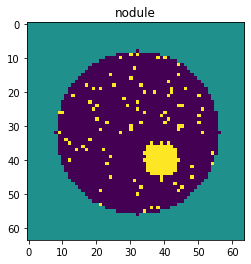

In [ ]:
visualize_data_categories(df1)

### Prepare Data 

In [ ]:
# (2 pts) TODO: write a function that (1) gets the 300 labeled wafer maps with their known labels,
#       (2) reshapes the wafer maps as a numpy array of shape [300, 64, 64, 1], 
#       (3) and converts the labels into numeric values 
def prepare_labeled_data_one(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    # Hint: use the function to_categorical to convert a class vector (integers) to binary class matrix.
    #       E.g. for use with categorical_crossentropy.
    df_known = df.loc[df['failureType'] != 'unknown']
    np_waferMap = np.empty((df_known.shape[0], 64, 64))
    for i in range(0, df_known.shape[0]):
        np_waferMap[i] = df_known.iloc[i, 0]
    np_waferMap = np_waferMap.reshape((df_known.shape[0], 64, 64, 1))
    
    dictionary = {'pass': 0,
                  'edge': 1,
                  'deform': 2,
                  'total_loss': 3,
                  'crack': 4,
                  'nodule': 5}
    np_failureType = df_known['failureType'].map(dictionary).to_numpy().reshape((df_known.shape[0], 1))
    np_failureType = to_categorical(np_failureType, num_classes=6, dtype='int')

    return np_waferMap, np_failureType

# (2 pts) TODO: write a function that (1) gets the 3000 unknown wafer maps, 
#       (2)  reshapes the wafer maps as a numpy array of shape [3000, 64, 64, 1]
def prepare_unlabeled_data_one(df: pd.DataFrame) -> np.ndarray:
    df_unknown = df.loc[df['failureType'] == 'unknown']
    np_waferMap =  np.empty((df_unknown.shape[0], 64, 64))
    for i in range(0, df_unknown.shape[0]):
        np_waferMap[i] = df_unknown.iloc[i, 0]

    return np_waferMap.reshape((df_unknown.shape[0], 64, 64, 1))

### Train/Validation Split

Q.2: (3 pts): Use at least three training and validation split ratio and show the validation prediction accuracy for each split ratio. Explain why the accuracy rises or drops in each configuration. Which ratio did you choose at the end?

> split_ratio = 0.2

Epoch 1/5
8/8 [==============================] - 11s 54ms/step - loss: 1.1256 - accuracy: 0.6750 - val_loss: 0.6000 - val_accuracy: 0.8000
Epoch 2/5
8/8 [==============================] - 0s 23ms/step - loss: 0.2861 - accuracy: 0.9167 - val_loss: 0.1439 - val_accuracy: 0.9833

> split_ratio = 0.25

Epoch 1/5
8/8 [==============================] - 2s 242ms/step - loss: 1.1472 - accuracy: 0.6222 - val_loss: 0.8574 - val_accuracy: 0.7600
Epoch 2/5
8/8 [==============================] - 2s 226ms/step - loss: 0.3400 - accuracy: 0.9067 - val_loss: 0.1599 - val_accuracy: 0.9733

> split_ratio = 0.3

Epoch 1/5
7/7 [==============================] - 2s 236ms/step - loss: 1.0583 - accuracy: 0.6667 - val_loss: 0.4424 - val_accuracy: 0.9556
Epoch 2/5
7/7 [==============================] - 2s 228ms/step - loss: 0.2463 - accuracy: 0.9571 - val_loss: 0.1581 - val_accuracy: 0.9444

> As the split ratio changes, the training data and the corresponding validation data differs in each configuration. The trained model fits the validation data to different extents, thus resulting in rise and drop in accuracy. I chose 0.25 as the split ratio since it produces better prediction accuracy overall.









In [ ]:
X1, y1 = prepare_labeled_data_one(df1)

# Split data into train and eval set
# TODO: Experiment with three training and validation split ratio 
split_ratio = 0.25
X1_train, X1_valid, y1_train, y1_valid = train_test_split(X1, y1, test_size=split_ratio, random_state=RANDOM_SEED)
logger.debug(f'X1_train: {X1_train.shape}, X1_valid: {X1_valid.shape}, y1_train: {y1_train.shape}, y1_valid: {y1_valid.shape}')

DEBUG:__main__:X1_train: (225, 64, 64, 1), X1_valid: (75, 64, 64, 1), y1_train: (225, 6), y1_valid: (75, 6)


### Tensorflow Neural Network Model 

In [ ]:
# Create a NN model
def create_model(image_shape=(64, 64, 1), n_categories=6, conv_activation='relu', conv_padding='same', output_activation='softmax'):
    # Initailize a sequential model: a model with plain stack of layers where each layer has exactly one input tensor and one output tensor.
    model = Sequential(name='wafer_clf')

    # Start with two CONV layers and one maxpooling in between for feature extraction
    # TODO: Experiment with other types of layers here.
    #model.add(Conv2D(filters=32, kernel_size=3, activation=conv_activation, input_shape=image_shape, padding=conv_padding))
    model.add(Conv2D(filters=32, kernel_size=3, activation=conv_activation, input_shape=image_shape, padding=conv_padding, kernel_regularizer=tf.keras.regularizers.L2(0.1)))
    model.add(MaxPooling2D((2, 2)))
    #model.add(Dropout(rate=0.2))
    #model.add(Conv2D(64, (3, 3), activation=conv_activation, padding=conv_padding))
    model.add(Conv2D(64, (3, 3), activation=conv_activation, padding=conv_padding, kernel_regularizer=tf.keras.regularizers.L2(0.1)))

    # Reshape the output to one dimensional array
    model.add(Flatten())

    # Use one dense layer for classification
    model.add(Dense(n_categories, activation=output_activation))
    #model.add(Dense(n_categories, activation=output_activation, kernel_regularizer=tf.keras.regularizers.L2(0.1)))

    return model

Q.3 (2 pts) : Provide the definitions for the following hyper-parameters.
1.   (1 pt) Number of filters of a CNN layer

> It means the dimensionality of the output space, i.e., the number of output filters in the convolution.

2.   (1 pt) Kernel size of a CNN layer

> It specifies the height and width of the 2D convolution window.


### Model Training

In [ ]:
# Create a model first
model = create_model()

# Compile model using accuracy to measure model performance
model.compile(optimizer='adam', 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

Q.4: (2 pts) Why is the provided network using a Softmax activation function in the final dense layer? Can we use a different activation function instead?

> Softmax function converts a vector of values into a normalized probability distribution, i.e., the elements of output vector are in range of (0, 1) and sum to 1, which is suitable for multiclass classification problems. For this reason, it is used in the final dense layer of the provided network.

> Better not. For instance, applying linear activation functions may lead to unbounded results, which are more suitable for regression problems. On the other hand, sigmoid function suits binary classification problems better, which is not the case here.



Q.5 (Bonus:  2 pts) We’ve learned Binary Cross Entropy loss function in class.  Why is the provided network using the Categorical Cross Entropy as loss function? How are the two related?

> Categorical cross entropy is used for being well suited to multiclass classification tasks, since one example can be considered to belong to a specific category with probability 1, and to other categories with probability 0.

> Binary cross entropy is intended to use with binary/multi-label classification tasks where the target value is 0 or 1 and categorical cross entropy is for multiclass classification. Both work for binary classification, but for categorical cross entropy the data needs to be changed to one-hot encoding.



In [ ]:
# Callback function for early stopping and restore the model weights with best accuracy
early_stop = EarlyStopping(monitor='val_accuracy', patience = 2, restore_best_weights=True)
callbacks_list = [early_stop]

In [ ]:
# Training: fit our data with the NN model

batch_size = 32
total_epochs = 10

history = model.fit(X1_train, y1_train, epochs=total_epochs, 
                    validation_data=(X1_valid, y1_valid),
                    callbacks=callbacks_list,
                    batch_size=batch_size,
                    )

Epoch 1/10
1/8 [==>...........................] - ETA: 0s - loss: 6.2005 - accuracy: 0.0312

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


8/8 [==============================] - 0s 40ms/step - loss: 5.1203 - accuracy: 0.6578 - val_loss: 4.0425 - val_accuracy: 0.8800
Epoch 2/10
8/8 [==============================] - 0s 29ms/step - loss: 3.6681 - accuracy: 0.8622 - val_loss: 3.2407 - val_accuracy: 0.9067
Epoch 3/10
8/8 [==============================] - 0s 34ms/step - loss: 2.9111 - accuracy: 0.9556 - val_loss: 2.6194 - val_accuracy: 0.9067
Epoch 4/10
8/8 [==============================] - 0s 32ms/step - loss: 2.3420 - accuracy: 0.9778 - val_loss: 2.0882 - val_accuracy: 0.9467
Epoch 5/10
8/8 [==============================] - 0s 30ms/step - loss: 1.9251 - accuracy: 0.9689 - val_loss: 1.9295 - val_accuracy: 0.8667
Epoch 6/10
8/8 [==============================] - 0s 32ms/step - loss: 1.5702 - accuracy: 0.9867 - val_loss: 1.4114 - val_accuracy: 0.9867
Epoch 7/10
8/8 [==============================] - 0s 36ms/step - loss: 1.2945 - accuracy: 0.9911 - val_loss: 1.2276 - val_accuracy: 0.9467
Epoch 8/10
8/8 [======================

Q.6: (8 pts) Make these four modification to the model provided above (one at a time) and explain how they affect the accuracy.

1.   (2 pts) Add Dropout layers and explain its effect

> Dropout layers offer a computationally cheap and effective regularization method to reduce overfitting and enhance generalization error.


2.   (2 pts) Add more CNN layers and explain its effect

> Since the size of the training data is relatively small, adding more CNN layers may lead to overfitting and reduces the validation accuracy.


3.   (2 pts) Add L2 regularization to CNN layers and explain its effect

> L2 regularization lowers the model complexity to prevent overfitting. The values of weight will decrease as L2 regularization penalizes the them. The weights then end up having less impact on the loss function which determines the error between the actual label and the predicted label.


4.   (2 pts) L2 regularization to Dense layers and explain its effect

> L2 regularization plays the same role as itself in the previous question. However, since the dense layer is the output layer, penalizing the weights of it causes the validation accuracy to vary greatly every epoch.



**From this point, proceed with a model and configuration of your choosing.**


In [ ]:
# Let's take a look at the model summary
model.summary()

Model: "wafer_clf"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 flatten_12 (Flatten)        (None, 65536)             0         
                                                                 
 dense_12 (Dense)            (None, 6)                 393222    
                                                                 
Total params: 412,038
Trainable params: 412,038
Non-trainable params: 0
___________________________________________________

### Image Augmentation

In [ ]:
# A helper function that converts one-hot encoding back to integer
def onehot2int(labels_in_onehot):
    try:
        label = np.argmax(labels_in_onehot, axis=1)
    except:
        label = np.argmax(labels_in_onehot)
    return label

# TODO: Implement a function that augments the data set by 
#       adding the rotated, or horizontally/vertically flipped image of each wafer map,
#       and repeats the labels accordingly
def augment_data(wafer_data: np.ndarray, wafer_labels: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    data_augmentation = Sequential([
        RandomFlip(mode="horizontal_and_vertical"), 
        RandomRotation(1)
    ])

    augmented_images = []
    augmented_labels = []

    for image, label in zip(wafer_data, wafer_labels):
        image = tf.expand_dims(image, 0)
        augmented_images.append(image)
        augmented_labels.append(label)

        # data augmentation for failed classes
        if label[0] != 1:
            for i in range(6):
                augmented_images.append(data_augmentation(image))
                augmented_labels.append(label)
    
    augmented_images = np.concatenate(augmented_images, axis=0)
    augmented_labels = np.array(augmented_labels)

    return augmented_images, augmented_labels

# (2 pts) TODO: Implement a function that takes our trained model to predict labels for the wafer maps
def predict_labels_part_one(data_to_predict: np.ndarray, model: tf.keras.Model) -> list:
    prediction = model.predict(data_to_predict)

    return onehot2int(prediction)

# TODO: Implement a function that computes the confusion matrix for the predicted result. 
def compute_confusion_matrix(pred_labels: np.ndarray, true_labels: np.ndarray) -> np.ndarray:
    # Calculate the confusion matrix
    return tf.math.confusion_matrix(true_labels, pred_labels)

# (2 pts) TODO: Implement a function that calculates the prediction accuracy.
def calculate_accuracy(pred_labels: np.ndarray, true_labels: np.ndarray) -> float:
    if pred_labels.shape[0] != true_labels.shape[0]:
        raise IndexError('Size of pred_labels does not match that of true_labels.')
    
    match = 0
    total = pred_labels.shape[0]
    for i in range(pred_labels.shape[0]):
        if pred_labels[i] != true_labels[i]:
            continue
        match = match + 1
    
    return match / total

In [ ]:
# Use image augmentation to generate 100 more images for each failing class (total of five)
# Note that the number of total augmented images obtained should be equal to: 169 pass + 131 others * 6 = 955
# Now if we count the number of images in each class, they are 169, 162, 174, 198, 150, 102. The data set is more even 
augmented_X1, augmented_y1 = augment_data(X1, y1)
logger.debug(f'augmented_X1: {augmented_X1.shape}, augmented_y1: {augmented_y1.shape}')

# Train Split 
split_ratio = 0.25
aug_X1_train, aug_X1_valid, aug_y1_train, aug_y1_valid = train_test_split(augmented_X1, augmented_y1, test_size=split_ratio, random_state=RANDOM_SEED)
logger.debug(f'aug_X1_train: {aug_X1_train.shape}, aug_X1_valid: {aug_X1_valid.shape}, aug_y1_train: {aug_y1_train.shape}, aug_y1_valid: {aug_y1_valid.shape}')

DEBUG:__main__:augmented_X1: (1086, 64, 64, 1), augmented_y1: (1086, 6)
DEBUG:__main__:aug_X1_train: (814, 64, 64, 1), aug_X1_valid: (272, 64, 64, 1), aug_y1_train: (814, 6), aug_y1_valid: (272, 6)


In [ ]:
# create a new model
model_with_aug = create_model()
logger.info(model_with_aug.summary())

# Compile model using accuracy to measure model performance
model_with_aug.compile(optimizer='adam', 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Callback function for early stopping and restore the model weights with best accuracy
early_stop = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True) # you might want to change the patience value here.
callbacks_list = [early_stop]

batch_size = 32
total_epochs = 10 # you might want to increase this until you see the loss converges

history = model_with_aug.fit(aug_X1_train, aug_y1_train, epochs=total_epochs, 
                    validation_data=(aug_X1_valid, aug_y1_valid),
                    callbacks=callbacks_list,
                    batch_size=batch_size,
                    )

INFO:__main__:None


Model: "wafer_clf"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 flatten_18 (Flatten)        (None, 65536)             0         
                                                                 
 dense_18 (Dense)            (None, 6)                 393222    
                                                                 
Total params: 412,038
Trainable params: 412,038
Non-trainable params: 0
___________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


26/26 [==============================] - 1s 28ms/step - loss: 3.8774 - accuracy: 0.7690 - val_loss: 2.4616 - val_accuracy: 0.8787
Epoch 2/10
26/26 [==============================] - 1s 27ms/step - loss: 1.7007 - accuracy: 0.9631 - val_loss: 1.2309 - val_accuracy: 0.9338
Epoch 3/10
26/26 [==============================] - 1s 25ms/step - loss: 0.8831 - accuracy: 0.9840 - val_loss: 0.7849 - val_accuracy: 0.9191
Epoch 4/10
26/26 [==============================] - 1s 25ms/step - loss: 0.5587 - accuracy: 0.9730 - val_loss: 0.4655 - val_accuracy: 0.9816
Epoch 5/10
26/26 [==============================] - 1s 24ms/step - loss: 0.3628 - accuracy: 0.9902 - val_loss: 0.3804 - val_accuracy: 0.9449
Epoch 6/10
26/26 [==============================] - 1s 26ms/step - loss: 0.3539 - accuracy: 0.9644 - val_loss: 0.3286 - val_accuracy: 0.9853
Epoch 7/10
26/26 [==============================] - 1s 25ms/step - loss: 0.2476 - accuracy: 1.0000 - val_loss: 0.2472 - val_accuracy: 0.9890
Epoch 8/10
26/26 [======

Q.7: (6 pts) Use image augmentation to generate 100 more images for each failing class (total of five, excluding 'pass') and retrain your model with the added images (5 pt for implementing the augment_data function). Did the performance of the retrained model improve or decrease (1 pt)? Image augmentation could be rotation, horizontal/vertical flip, etc.

> The performance of the retrained model has an obvious improvement. The validation accuracy converged to a high figure in early epoches and does not fluctuate much afterwards.



In [ ]:
# Get the predicted results for the validation data
pred_y1_val = predict_labels_part_one(aug_X1_valid, model_with_aug)

# Get the confusion matrix for the validation predictions
cm = compute_confusion_matrix(pred_y1_val, onehot2int(aug_y1_valid))
logger.info(f'Confusion matrix of the tsmc validation data: \n{cm}\n')

# Get validation accuracy
acc = calculate_accuracy(pred_y1_val, onehot2int(aug_y1_valid))
logger.info(f'The validation accuracy is {acc}.')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
INFO:__main__:Confusion matrix of the tsmc validation data: 
[[44  0  0  0  0  0]
 [ 0 38  0  0  0  0]
 [ 0  0 66  0  0  0]
 [ 0  0  0 41  0  0]
 [ 0  0  0  0 46  0]
 [ 0  0  0  0  2 35]]

INFO:__main__:The validation accuracy is 0.9926470588235294.


Q.8: (2 pts) Show the confusion matrix for the validation predictions (include the axis values).

```
[[44  0  0  0  0  0]
 [ 0 38  0  0  0  0]
 [ 0  0 66  0  0  0]
 [ 0  0  0 41  0  0]
 [ 0  0  0  0 46  0]
 [ 0  0  0  0  2 35]]
```







### Unknown Data Prediction

In [ ]:
# Call our helper function to get the unknown wafer maps
X1_unknown = prepare_unlabeled_data_one(df1)

# Call our helper function to predict labels for the unknowns
pred_labels = predict_labels_part_one(X1_unknown, model_with_aug)
result = list(map({0: 'pass', 1:'edge', 2: 'deform', 3: 'total_loss', 4: 'crack', 5: 'nodule'}.get, pred_labels))

# Save the labels to csv file and submit to GradeScope
np.savetxt("./prediction.csv", result, fmt='%s', delimiter=",")
logger.info(f'You should now see the prediction.csv file saved on your Colab file system.\nYou can right click on it and download to your local folder, and then submit the file to GradeScope.')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
INFO:__main__:You should now see the prediction.csv file saved on your Colab file system.
You can right click on it and download to your local folder, and then submit the file to GradeScope.


Q.9: (2 pts) After submitting to Gradescope, are you able to achieve ~95% accuracy on the unknown dataset? If yes, skip this part. If not, write a paragraph explaining what is the main problem that caused this and how you could fix it if given the necessary resources.

----------
# Part 2: Classification on the TSMC Data Set
----------

At this point, you should already have a good understanding of a CNN model. We will use thearchitecture you have configured from part one to train and evaluate on a real-world wafer dataset from TSMC [1].

### Data Downloading

In [ ]:
# Data loading and visualizing are the same as part 1
data_url_2 = 'https://ucsb.box.com/shared/static/f2x51xl9p1hvh9sqwww752ayr6hghdub.pkl' # url
save_path_2 = './hw1/dataset_two.pkl' 

dataset_2 = download(save_path_2, data_url_2)
df2 = pd.read_pickle(save_path_2)
logger.debug(df2.info())

INFO:__main__:File saved to ./hw1/dataset_two.pkl
DEBUG:__main__:None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 904 entries, 0 to 23051
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   lotName      904 non-null    object
 1   waferNumber  904 non-null    int64 
 2   tsmcIndex    904 non-null    int64 
 3   dieCount     904 non-null    int64 
 4   failureType  904 non-null    object
 5   waferMap     904 non-null    object
dtypes: int64(3), object(3)
memory usage: 49.4+ KB


Q.10: (2 pts) Download the second data set and visualize the failure types as you did in part one.

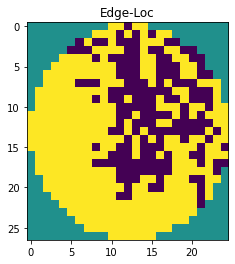

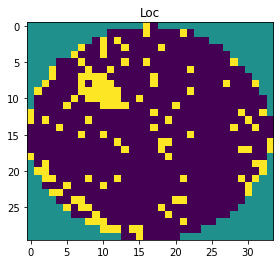

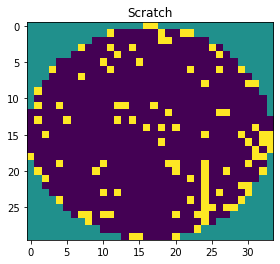

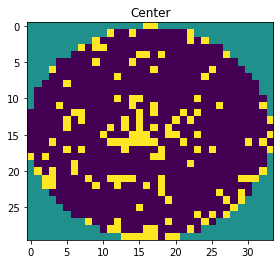

In [ ]:
visualize_data_categories(df2)

### Prepare Data

In [ ]:
# The function resizes the wafer to specified output shape
def resize_wafer_data(wafer_data: np.ndarray, output_shape: tuple=(64, 64)) -> np.ndarray:
    return resize(wafer_data, output_shape, preserve_range=True)

# TODO: Similar to part one, write a function that (1) gets the wafer maps with their corresponding labels,
#       (2) reshapes the wafer maps as a numpy array of shape [x, 64, 64, 1], 
#       (3) and converts the labels into numeric values 
def prepare_data_two(df: pd.DataFrame) -> Tuple[np.ndarray, list]:
    # Resize_wafer_data function to resize the wafer map to a larger size
    resized = df['waferMap'].apply(resize_wafer_data) # this takes about 30 sec
    
    np_waferMap = np.empty((df.shape[0], 64, 64))
    for i in range(df.shape[0]):
        np_waferMap[i] = resized.iloc[i]
    np_waferMap = np_waferMap.reshape((df.shape[0], 64, 64, 1))

    dictionary = {'Edge-Loc': 0,
                  'Loc':1,
                  'Scratch':2,
                  'Center': 3}
    np_failureType = df['failureType'].map(dictionary).to_numpy().reshape((df.shape[0], 1))
    np_failureType = to_categorical(np_failureType, num_classes=4, dtype='int')

    return np_waferMap, np_failureType

In [ ]:
X2, y2 = prepare_data_two(df2)

# Split data into train and eval set with the give ratio
split_ratio = 0.33
X2_train, X2_valid, y2_train, y2_valid = train_test_split(X2, y2, test_size=split_ratio, random_state=RANDOM_SEED)
logger.debug(f'X2_train: {X2_train.shape}, X2_valid: {X2_valid.shape}, y2_train: {y2_train.shape}, y2_valid: {y2_valid.shape}')

DEBUG:__main__:X2_train: (605, 64, 64, 1), X2_valid: (299, 64, 64, 1), y2_train: (605, 4), y2_valid: (299, 4)


### Model Training and Evaluation

In [ ]:
# The following is similar to part one
# Create a model first
model2 = create_model(n_categories=4)

# Compile model using accuracy to measure model performance
model2.compile(optimizer='adam', 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
# Callback function for early stopping and restore the model weights with best accuracy
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True) # you might want to change the patience
callbacks_list = [early_stop]

# Training: fit our data with the NN model

batch_size = 32
total_epochs = 20 # you might want to increase this until you see the loss converges

history = model2.fit(X2_train, y2_train, epochs=total_epochs, 
                    validation_data=(X2_valid, y2_valid),
                    callbacks=callbacks_list,
                    batch_size=batch_size,
                    )

Epoch 1/30
 1/19 [>.............................] - ETA: 0s - loss: 5.9355 - accuracy: 0.0938

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


19/19 [==============================] - 1s 31ms/step - loss: 4.7474 - accuracy: 0.5636 - val_loss: 3.5106 - val_accuracy: 0.7157
Epoch 2/30
19/19 [==============================] - 1s 28ms/step - loss: 2.8154 - accuracy: 0.7388 - val_loss: 2.2011 - val_accuracy: 0.7559
Epoch 3/30
19/19 [==============================] - 1s 30ms/step - loss: 1.8007 - accuracy: 0.7917 - val_loss: 1.5185 - val_accuracy: 0.8328
Epoch 4/30
19/19 [==============================] - 1s 33ms/step - loss: 1.2275 - accuracy: 0.8430 - val_loss: 1.3741 - val_accuracy: 0.6990
Epoch 5/30
19/19 [==============================] - 1s 28ms/step - loss: 0.9269 - accuracy: 0.8678 - val_loss: 0.9617 - val_accuracy: 0.8227
Epoch 6/30
19/19 [==============================] - 1s 30ms/step - loss: 0.7003 - accuracy: 0.9190 - val_loss: 0.8912 - val_accuracy: 0.7926
Epoch 7/30
19/19 [==============================] - 1s 30ms/step - loss: 0.5707 - accuracy: 0.9240 - val_loss: 0.8674 - val_accuracy: 0.7860
Epoch 8/30
19/19 [======

In [ ]:
# (2 pts) TODO: Similar to part one, implement a function that takes our trained model to predict labels for the wafer maps
def predict_labels_part_two(data_to_predict: np.ndarray, model: tf.keras.Model) -> list:
    prediction = model.predict(data_to_predict)

    return onehot2int(prediction)

# TODO: Similar to part one, implement a function that computes the confusion matrix for the predicted result. 
#       You can also reuse the function from part one, if possible. 
def compute_confusion_matrix(pred_labels: np.ndarray, true_labels: np.ndarray) -> np.ndarray:
    # Calculate the confusion matrix
    return tf.math.confusion_matrix(true_labels, pred_labels)

# TODO: Implement a function that calculates the prediction accuracy. 
#       You can also reuse the function from part one, if possible. 
def calculate_accuracy(pred_labels: np.ndarray, true_labels: np.ndarray) -> float:
    if pred_labels.shape[0] != true_labels.shape[0]:
        raise IndexError('Size of pred_labels does not match that of true_labels.')
    
    match = 0
    total = pred_labels.shape[0]
    for i in range(pred_labels.shape[0]):
        if pred_labels[i] != true_labels[i]:
            continue
        match = match + 1
    
    return match / total

In [ ]:
pred_y2_val = predict_labels_part_two(X2_valid, model2)

cm = compute_confusion_matrix(pred_y2_val, onehot2int(y2_valid))
logger.info(f'The confusion matrix is\n {cm}.')

acc = calculate_accuracy(pred_y2_val, onehot2int(y2_valid))
logger.info(f'The validation accuracy is {acc}.')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
INFO:__main__:The confusion matrix is
 [[139   5   0   0]
 [ 18  82   6   4]
 [  2  11   3   0]
 [  3   1   0  25]].
INFO:__main__:The validation accuracy is 0.8327759197324415.


Q.11: (8 pts) Prepare data (2 pts), use the same model architecture as in part one to train and evaluate this TSMC data set (4 pts), and show the confusion matrix for the validation predictions (2 pts). Are the accuracy results the same across all the categories?

> No. The category "Edge-Loc" has the best accuracy. This result is not surprsing since "Edge-Loc" has the largest proportion among all the failure types in the training data.



Q.12: (4 pts) Were you able to get a good accuracy (> 95%) on this TSMC data set? If not, explain why the same model performed worse?

>The training data provided does not have a balanced distribution of categories.Plus, we did not perform data augmentation for the categories with lower frequencies. It is expected to havea worse performance in comparison with that of the Part I.



Q.13: (272B only:  10 pts) Study the paper where the TSMC data set was first proposed [?]. Drawing inspirations from this paper, provide possible solutions to improve the classification accuracy of this data set. (Even better if you come up with your original ideas.)

1.   Data augmentation: using augmentation not only increases the original dataset, but also allows having a more balanced category distribution to avoid the NN model being biased and overfitting.
2.   Noise reduction: Wafer maps are accompanied with noise. However, applying noise reduction does not gurantee producing beneficial results only. While using noise reduction may extratct essential features (e.g., donut pattern), it may also destruct certain features (e.g., edge ring). The solution proposed by the paper is to perform with- and without noise reduction simultaneously. This method is proved to have the optimal performance.
3.   Change the layer structure of NN: I chose L2 regularization for the dataset created by TA. However, this might not be the optimal case for the TSMC dataset. It will be ideal to specialize a new create_model function for it.
4.   New training/testing data split: Allow the category distribution of both datasets to be similar. Then we can have a better idea of how well-rounded the trained NN model might be.


